# BIA 6304 Text Mining, Fall 2017
## Final Project
### Stuent:  Leonardo Ji
### 10/6/2017

In [2]:
import pandas as pd   #we almost always need pandas because we like data frames
import numpy as np
from bs4 import BeautifulSoup
import urllib3
import json
import math
import re
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt


pd.set_option('display.max_colwidth', 150) #important for getting all the text

### Gather data

In [ ]:
ucern = {}
#http://urllib3.readthedocs.io/en/latest/user-guide.html
http = urllib3.PoolManager()
headers = urllib3.util.make_headers(basic_auth='user:changeit')

url = 'https://connectupgradedev.ucern.com/api/core/v3/places/1356468/contents?sort=dateCreatedDesc&fields=%40all&filter=place%28https%3A//connectupgradedev.ucern.com/api/core/v3/places/1356468%29&abridged=false&count=100'
 
def loadContent(jsondata, ucern, count):
    for content in jsondata['list']:
        ucern[count] = {}
        ucern[count]['contentID'] = content['contentID'];
        if ('type' in content):
            ucern[count]['type'] = content['type']
        if ('subject' in content):
            ucern[count]['subject'] = content['subject']
        if ('viewCount' in content):
            ucern[count]['viewCount'] = content['viewCount']
        if ('replyCount' in content):
            ucern[count]['replyCount'] = content['replyCount']
        if ('lastActivityDate' in content):
            ucern[count]['lastActivityDate'] = content['lastActivityDate']
        if ('author' in content):
            ucern[count]['author'] = content['author']['displayName']
        if ('content' in content):
            # remove html tags using BeautifulSoup
            soup = BeautifulSoup(content['content']['text'], "lxml")
            ucern[count]['content'] = soup.get_text()
        if ('question' in content):
            ucern[count]['question'] = content['question']
            ucern[count]['resolved'] = False
            if ('resolved' in content and content['resolved'] == 'resolved'):
                ucern[count]['resolved'] = True
                if ('answer' in content):
                    ucern[count]['answerLink'] = content['answer']
                    req2 = http.request('GET', content['answer'], headers=headers)
                    json2 = json.loads(req2.data)
                    if ('content' in json2):
                        # remove html tags using BeautifulSoup
                        soup2 = BeautifulSoup(json2['content']['text'], "lxml")
                        ucern[count]['answer'] = soup2.get_text()
                        if ('author' in json2):
                            ucern[count]['answerAuthor'] = json2['author']['displayName']
        count = count + 1
    return count

i = 0
count = 0
while(url and i < 10):
    #print(url)
    req = http.request('GET', url, headers=headers)
    jsondata = json.loads(req.data)
    
    count = loadContent(jsondata, ucern, count)
    
    if (jsondata and jsondata['links'] and 'next' in jsondata['links']):
        url = jsondata['links']['next']
    i = i + 1
    
    
    
# convert data to panda dataframe
ucernDf = pd.DataFrame.from_dict(ucern,orient="index")

In [3]:
# save data to disk
#ucernDf.to_pickle("C:/Users/lj015625/Desktop/Text Mining/FinalProject/ucernDf.bin")
#ucernDf.to_csv("C:/Users/lj015625/Desktop/Text Mining/FinalProject/ucernDf.csv")
ucernDf = pd.read_pickle("C:/Users/lj015625/Desktop/Text Mining/FinalProject/ucernDf.bin")

### How many are discussions, how many discussions are questions?

(848, 13)

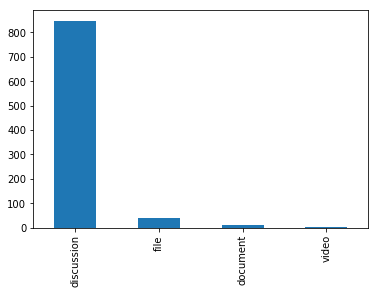

In [4]:
%matplotlib inline
ucernDf['type'].value_counts().plot(kind='bar')
ucernDf = ucernDf[(ucernDf['type'] == 'discussion')]
ucernDf.shape

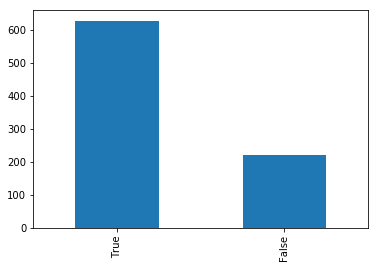

In [6]:
# get a feel for the distribution
%matplotlib inline
ucernDf['question'].value_counts().plot(kind='bar')

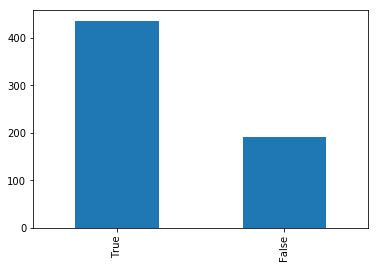

In [7]:
ucernDf = ucernDf[(ucernDf['question'] == True)]
ucernDf['resolved'].value_counts()
ucernDf['resolved'].value_counts().plot(kind='bar')

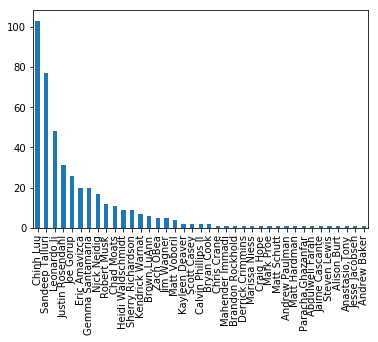

In [8]:
ucernDf['answerAuthor'].value_counts().plot(kind='bar')

In [9]:
ucernDf = ucernDf.reset_index()
ucernDf.shape

(627, 14)

In [105]:
ucernDf.to_pickle("C:/Users/lj015625/Desktop/Text Mining/FinalProject/ucernquestionDf.bin")

### Pre-processing to combine special terms, remove stop words.

In [10]:
# start preprocessing
# Preprocessing to replace words
my_dict = {'care management':'caremanagement', 'case management' : 'caremanagement', 'cm' : 'caremanagement', 
           'worklists':'worklist','carefinder pro':'carefinderpro','care finder pro':'carefinderpro', 'tlc':'ensocare',
           'um worklist': 'umWorklist','discharge worklist':'dischargeWorklist','assignment worklist':'assignmentWorklist',
           'clinical reviews':'clinicalreview','clinical review':'clinicalreview','errors' : 'error', 'visit information' : 'visitInformation',
           'insurance information':'insuranceInformation',
           'discharge planning':'dischargePlanning', 'post-acute':'postacute','post acute':'postacute','don\'t':'donot'}

def multiple_replace(dict, text): 
  """ Replace in 'text' all occurences of any key in the given
  dictionary by its corresponding value.  Returns the new tring.""" 
  lowerText = str(text).lower()

  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], lowerText)

ucernDf['cleancontent'] = ucernDf.content.apply(lambda x: multiple_replace(my_dict, x))
ucernDf['cleansubject'] = ucernDf.subject.apply(lambda x: multiple_replace(my_dict, x))
ucernDf['cleananswer'] = ucernDf.answer.apply(lambda x: multiple_replace(my_dict, x))


In [11]:
skl_stopwords = text.ENGLISH_STOP_WORDS
myStopwords = set(skl_stopwords)
print(len(myStopwords))
# Remove common exception stack trace tokens
myStopwords.update(set(['caremanagement','http','https','java','javax','com','cerner','service','enterprise','server','jdbc','internal','run','invoke',
                        'common','transaction','org','execute','client','reflect','sun','reflect','requesthandler','doprivileged','transactionmanager','container',
                        'lang','security','auth','native','method','subject','thread','accesscontroller','delegatingmethodaccessorimpl','interceptorchainimpl','servercontainer',
                        'cadence', 'intercept', 'caremanagementserver', 'util','unable','nativemethodaccessorimpl','servicemanager','rrservice', 'executors','spcinterceptor',
                        '00','01','10','11','12', '13', '14', '15', '16', '17', '53','91','160']))
print(len(myStopwords))

318
377


In [12]:
ps = PorterStemmer() #define method (http://www.nltk.org/api/nltk.stem.html#nltk.stem.porter.PorterStemmer)
ucernDf['cleansubject'] = [ps.stem(word) for word in ucernDf['cleansubject']] 

### Convert text to Document Matrix

In [13]:
#1. CV on content
cv1 = CountVectorizer(lowercase=True, 
                     stop_words=myStopwords,
                     binary=False,
                     max_df=0.90, 
                     min_df=0.05,
                     ngram_range = (1,3)) 

cv_dm = cv1.fit_transform(ucernDf['cleancontent'])
print(cv_dm.shape)
names = cv1.get_feature_names()
print(type(names), len(names))

count = np.sum(cv_dm.toarray(), axis = 0).tolist()
print(type(count), len(count))
count_df = pd.DataFrame(count, index = names, columns = ['count'])

(627, 197)
<class 'list'> 197
<class 'list'> 197


In [14]:
#2. CV on subject only
cv2 = CountVectorizer(lowercase=True, 
                     stop_words=myStopwords,
                     binary=False,
                     max_df=0.90, 
                     min_df=0.01,
                     ngram_range = (1,3)) 
cv_dm2 = cv2.fit_transform(ucernDf['cleansubject'])
print(cv_dm2.shape)
names2 = cv2.get_feature_names()
print(type(names2), len(names2))

count2 = np.sum(cv_dm2.toarray(), axis = 0).tolist()
print(type(count2), len(count2))
count_df2 = pd.DataFrame(count2, index = names2, columns = ['count'])

(627, 102)
<class 'list'> 102
<class 'list'> 102


### Clustering on Subject text, and see most frequent terms in each clusters and resolve ratio.

In [15]:
# K Mean on Subject
k_range = range(3,20)
k_means_set = [KMeans(n_clusters=k,init='k-means++', max_iter=100, random_state = 42).fit(cv_dm2) for k in k_range]
centroids_list = [km_result.cluster_centers_ for km_result in k_means_set]

# calc euclidean dist from each point to each cluster center
from scipy.spatial.distance import cdist, pdist
cv_dm_array = cv_dm2.toarray()

k_euclid = [cdist(cv_dm_array, thing, 'euclidean') for thing in centroids_list]
distance_set = [np.min(k_euc, axis=1) for k_euc in k_euclid]
# total within-cluster sum of squares
wcss = [np.sum(distance**2) for distance in distance_set]
# total sum of squares
tss  = np.sum(pdist(cv_dm_array)**2) / cv_dm_array.shape[0]
# between cluster sum of squares
bss = tss - wcss

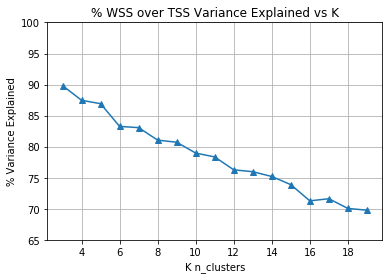

In [16]:
# plot elbow chart wss/tss
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, wcss/tss*100, '^-')
ax.set_ylim((65,100))
plt.grid(True)
plt.xlabel('K n_clusters')
plt.ylabel('% Variance Explained')
plt.title('% WSS over TSS Variance Explained vs K')
withness = wcss/tss*100;

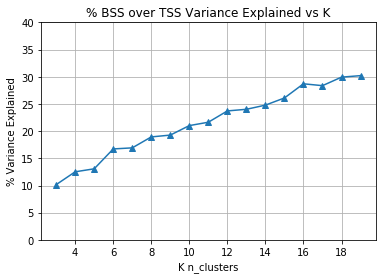

In [17]:
# plot elbow chart bss/tss
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k_range, bss/tss*100, '^-')
ax.set_ylim((0,40))
plt.grid(True)
plt.xlabel('K n_clusters')
plt.ylabel('% Variance Explained')
plt.title('% BSS over TSS Variance Explained vs K')
betwness = bss/tss*100

In [18]:
# create 6 clusters
km = KMeans(n_clusters=6, init='k-means++', max_iter=100, random_state = 42)
news_k = km.fit(cv_dm_array)
clusters = km.labels_.tolist()
ucernDf['clusters'] = clusters

print(ucernDf['clusters'].value_counts())

0    367
1    113
2     45
4     39
3     36
5     27
Name: clusters, dtype: int64


In [19]:
cluster1 = ucernDf[(ucernDf['clusters'] == 0)]
cluster2 = ucernDf[(ucernDf['clusters'] == 1)]
cluster3 = ucernDf[(ucernDf['clusters'] == 2)]
cluster4 = ucernDf[(ucernDf['clusters'] == 3)]
cluster5 = ucernDf[(ucernDf['clusters'] == 4)]
cluster6 = ucernDf[(ucernDf['clusters'] == 5)]

In [20]:
# cluster 1
cluster1_cv_dm_array = cv_dm_array[cluster1.index];
print(cluster1_cv_dm_array.shape)
cluster1_count = np.sum(cluster1_cv_dm_array, axis = 0).tolist()
cluster1_count_df = pd.DataFrame(cluster1_count, index = names2, columns = ['count'])
cluster1_count_df.sort_values(['count'], ascending = False).head(10)
print(cluster1.shape)

(367, 102)
(367, 18)


In [21]:
# cluster 2
cluster2_cv_dm_array = cv_dm_array[cluster2.index];
print(cluster2_cv_dm_array.shape)
cluster2_count = np.sum(cluster2_cv_dm_array, axis = 0).tolist()
cluster2_count_df = pd.DataFrame(cluster2_count, index = names2, columns = ['count'])
cluster2_count_df.sort_values(['count'], ascending = False).head(10)

(113, 102)


,count
error,114
message,11
error message,10
clinicalreview,10
interqual,9
script error,8
report,8
script,8
packet,6
days,6


In [22]:
# cluster 3
cluster3_cv_dm_array = cv_dm_array[cluster3.index];
print(cluster3_cv_dm_array.shape)
cluster3_count = np.sum(cluster3_cv_dm_array, axis = 0).tolist()
cluster3_count_df = pd.DataFrame(cluster3_count, index = names2, columns = ['count'])
cluster3_count_df.sort_values(['count'], ascending = False).head(10)


(45, 102)


,count
postacute,29
fax,23
placement,11
services,10
postacute services,9
postacute placement,8
status,6
error,4
report,4
compon,4


In [23]:
# cluster 4
cluster4_cv_dm_array = cv_dm_array[cluster4.index];
print(cluster4_cv_dm_array.shape)
cluster4_count = np.sum(cluster4_cv_dm_array, axis = 0).tolist()
cluster4_count_df = pd.DataFrame(cluster4_count, index = names2, columns = ['count'])
cluster4_count_df.sort_values(['count'], ascending = False).head(10)

(36, 102)


,count
worklist,39
error,7
issue,4
review,4
patient,4
script,3
script error,3
print,3
dischargeplanning,3
date,2


In [24]:
# cluster 5
cluster5_cv_dm_array = cv_dm_array[cluster5.index];
print(cluster5_cv_dm_array.shape)
cluster5_count = np.sum(cluster5_cv_dm_array, axis = 0).tolist()
cluster5_count_df = pd.DataFrame(cluster5_count, index = names2, columns = ['count'])
cluster5_count_df.sort_values(['count'], ascending = False).head(10)

(39, 102)


,count
clinicalreview,39
fax,9
mpage,4
mcg,3
open,3
showing,2
summary,2
issue,2
pulling,2
faxing,2


In [25]:
# cluster 6
cluster6_cv_dm_array = cv_dm_array[cluster6.index];
print(cluster6_cv_dm_array.shape)
cluster6_count = np.sum(cluster6_cv_dm_array, axis = 0).tolist()
cluster6_count_df = pd.DataFrame(cluster6_count, index = names2, columns = ['count'])
cluster6_count_df.sort_values(['count'], ascending = False).head(10)

(27, 102)


,count
ensocare,28
error,6
packets,5
carefinderpro,4
bedrock,3
package,2
quest,2
issue,2
work,2
upload,2


In [26]:
## Get each group resolve ratio
cluster1['resolved'].value_counts(normalize=True)

True     0.716621
False    0.283379
Name: resolved, dtype: float64

In [27]:
cluster2['resolved'].value_counts(normalize=True)

True     0.646018
False    0.353982
Name: resolved, dtype: float64

In [28]:
cluster3['resolved'].value_counts(normalize=True)

True     0.711111
False    0.288889
Name: resolved, dtype: float64

In [29]:
cluster4['resolved'].value_counts(normalize=True)

True     0.722222
False    0.277778
Name: resolved, dtype: float64

In [30]:
cluster5['resolved'].value_counts(normalize=True)

True     0.717949
False    0.282051
Name: resolved, dtype: float64

In [31]:
cluster6['resolved'].value_counts(normalize=True)

True     0.518519
False    0.481481
Name: resolved, dtype: float64

### Predicting Resolved status from text

In [32]:
# Classification to predict resolved status from question text
# train test split
# data are X, labels are y
ucernDf['resolved'] = ucernDf.resolved.apply(str) # convert boolean to str for target variable
print(ucernDf.resolved.unique())

#1. Tfidf on content
tfidf1 = TfidfVectorizer(lowercase = True, 
                        stop_words=myStopwords, 
                        max_df=0.90, 
                        min_df=0.05,
                        ngram_range = (1,3))

tfidf_dm = tfidf1.fit_transform(ucernDf['cleancontent'])
print(tfidf_dm.shape)
names = tfidf1.get_feature_names()
print(type(names), len(names))



['True' 'False']
(627, 197)
<class 'list'> 197


In [85]:
X = tfidf_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
y = ucernDf['resolved'].values #this is an array of labels


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(438, 197)
(189, 197)
(438,)
(189,)


In [86]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )
# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)

print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

mean: 0.607 (std: 0.037)

0.650793650794
accuracy: 0.650793650794
             precision    recall  f1-score   support

      False       0.42      0.44      0.43        57
       True       0.75      0.74      0.75       132

avg / total       0.65      0.65      0.65       189



In [87]:
# Random Forest
clf = RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(X, y)
clf1_expected = y_test
clf1_predicted = clf.predict(X_test)

print(clf.score(X_test,y_test))
#print(clf.feature_importances_)

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.698412698413
accuracy: 0.698412698413
             precision    recall  f1-score   support

      False       0.00      0.00      0.00        57
       True       0.70      1.00      0.82       132

avg / total       0.49      0.70      0.57       189



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [90]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.703703703704
accuracy: 0.703703703704
             precision    recall  f1-score   support

      False       1.00      0.02      0.03        57
       True       0.70      1.00      0.82       132

avg / total       0.79      0.70      0.59       189



In [91]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

# fit a Naive Bayes model to the data
model = GaussianNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))

GaussianNB(priors=None)
0.597883597884
accuracy: 0.597883597884
             precision    recall  f1-score   support

      False       0.39      0.56      0.46        57
       True       0.76      0.61      0.68       132

avg / total       0.65      0.60      0.61       189



In [92]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

print(model.score(X_test, y_test))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.708994708995
accuracy: 0.708994708995
             precision    recall  f1-score   support

      False       0.62      0.09      0.15        57
       True       0.71      0.98      0.82       132

avg / total       0.69      0.71      0.62       189

0.708994708995


In [93]:
# KNN
# creating odd list of K for KNN
myList = list(range(1,35))

# subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

#takes some time, get a soda...
# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

The optimal number of neighbors is 19


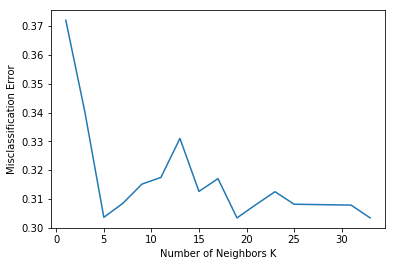

In [94]:
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [95]:
# instantiate learning model 
model = KNeighborsClassifier(n_neighbors=19)
model.fit(X_train, y_train)

# make predictions
knn2_expected = y_test
knn2_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(knn2_expected, knn2_predicted)))
print(metrics.classification_report(knn2_expected, knn2_predicted))


0.708994708995
accuracy: 0.708994708995
             precision    recall  f1-score   support

      False       0.67      0.07      0.13        57
       True       0.71      0.98      0.83       132

avg / total       0.70      0.71      0.61       189



### Add viewCount and replyCount to the classification models see if results is better.

In [98]:
# add viewCount and replyCount to the classification models
print(tfidf_dm.shape)
Xdf = pd.DataFrame(tfidf_dm.toarray())
Xdf['replyCound'] = np.transpose(ucernDf.replyCount.values)
ucernDf['authorCode'] = ucernDf['author'].astype('category').cat.codes
Xdf['authorCode'] = np.transpose(ucernDf.authorCode.values)
print(Xdf.shape)

X_train, X_test, y_train, y_test = train_test_split(Xdf, y, test_size=0.3, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(627, 197)
(627, 199)
(438, 199)
(189, 199)
(438,)
(189,)


In [99]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

print(model.score(X_test, y_test))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.708994708995
accuracy: 0.708994708995
             precision    recall  f1-score   support

      False       0.58      0.12      0.20        57
       True       0.72      0.96      0.82       132

avg / total       0.68      0.71      0.64       189

0.708994708995


### Topics modeling

In [100]:
# topic 
tfidf = TfidfVectorizer(lowercase=True, 
                        stop_words= myStopwords, 
                        max_df=0.90, 
                        min_df=0.05,
                        ngram_range = (1,3)) 
tfidf_dm = tfidf.fit_transform(ucernDf['cleancontent'])
tfidf_dm.shape

n_topics = 6
n_top_words = 5

In [44]:
# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf_dm)

feature_names = tfidf.get_feature_names()
print(len(feature_names))

print("\nTopics for news in NMF model:")
# nice function for printing topic information - 
# https://stackoverflow.com/questions/34429635/topic-modelling-assign-a-document-with-top-2-topics-as-category-label-sklear

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
print_top_words(nmf, feature_names, n_top_words)

197

Topics for news in NMF model:
Topic #0:
error message error message script log
Topic #1:
postacute exception placement type cernerasp
Topic #2:
patient issue time user attached
Topic #3:
report data id days query
Topic #4:
component mpages mpage bedrock set
Topic #5:
fax clinicalreview send review cr



In [45]:
# x = [1, 2, 3]
# y = [4, 5, 6]
# zipped = zip(x, y)
# list(zipped)
# [(1, 4), (2, 5), (3, 6)]
#define a function for cosine similarity - the latest version in sklearn doesn't take vectors
#compute cosine similarity of v1 to v2: (v1 dot v1)/(||v1||*||v2||)'
def cosine_similarity(a, b):
    return sum([i*j for i,j in zip(a, b)])/(math.sqrt(sum([i*i for i in a]))* math.sqrt(sum([i*i for i in b])))

In [46]:
# add topic to original data frame
# define a function for determining the most similar topic
def topic_sim(arr, feature_names, n_top_words, topics):
    """
    @type  arr: array of number
    @param arr: vectorizer number in an array.
    @type  feature_names: array of string
    @param feature_names: The array of feature names.
    @type  n_top_words: number
    @param n_top_words: The number of topics to return.
    @type  topics: array of string
    @param topics: Complete list of topics from topic extraction.
    
    @rtype:   top topics
    @return:  top topics in string separated by space.
    """
    top_sim = 0
    top_topic = np.array([])
    # iterate over topics
    for idx, topic in enumerate(topics):
        # calculate cosine similarity - substitute euclidean distance if that is your preferred metric
        # could switch to euclidean_distances
        sim = cosine_similarity(arr, topic)
        if sim > top_sim:
            top_sim = sim
            top_topic = topic
    
    # argsort sort is in ascending order, so pick last n_top_words from it
    selected_topic_index = top_topic.argsort()[:-n_top_words-1:-1]
    # return the text feature names by indeing back into feature_names (assigned earlier)   
    return " ".join([feature_names[i] for i in selected_topic_index])

In [47]:
ucernDf['nmf_topics'] = np.ma.apply_along_axis(topic_sim, axis=1, 
        arr=tfidf_dm.toarray(), feature_names=tfidf.get_feature_names(), n_top_words=3, topics=nmf.components_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [48]:
# SVD 
# Fit LSA. Use algorithm = “randomized” for large datasets
# apply to our text examples again
lsa = TruncatedSVD(6, algorithm = 'arpack')
cvnorm_lsa = lsa.fit_transform(tfidf_dm)
cvnorm_lsa = Normalizer(copy=False).fit_transform(cvnorm_lsa)


pd.DataFrame(lsa.components_, index = ["component_1","component_2","component_3","component_4","component_5","component_6"],
             columns = tfidf.get_feature_names())

pd.DataFrame(cvnorm_lsa, index = ucernDf['cleancontent'], 
             columns = ["component_1","component_2","component_3","component_4","component_5","component_6"])

#use LSA for topic extraction
feature_names = tfidf.get_feature_names()

print("\nTopics for texts in LSA model:")
print_top_words(lsa, feature_names, n_top_words)


Topics for texts in LSA model:
Topic #0:
error issue patient report attached
Topic #1:
error exception cernerasp postacute health
Topic #2:
error interqual message error message review
Topic #3:
report fax error message data
Topic #4:
report mpages component mpage packages
Topic #5:
fax postacute component placement code



In [49]:
ucernDf['lsa_topics'] = np.ma.apply_along_axis(topic_sim, axis=1, 
       arr=tfidf_dm.toarray(), feature_names=tfidf.get_feature_names(), n_top_words=3, topics=lsa.components_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [50]:
# LDA
# Fit the LDA model
lda = LatentDirichletAllocation(n_topics=6, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
lda.fit(tfidf_dm)

feature_names = tfidf.get_feature_names()

#what are the topics for this corpus?
print("\nTopics for texts in LDA model:")
print_top_words(lda, feature_names, n_top_words)


Topics for texts in LDA model:
Topic #0:
fax add way ensocare end
Topic #1:
note create let know let did
Topic #2:
package fax field number error
Topic #3:
error issue attached clinicalreview review
Topic #4:
report patient component date discharge
Topic #5:
exception cernerasp bedrock postacute thanks



In [51]:
ucernDf['lda_topics'] = np.ma.apply_along_axis(topic_sim, axis=1, 
       arr=tfidf_dm.toarray(), feature_names=tfidf.get_feature_names(), n_top_words=3, topics=lda.components_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


### Use KMean Clustering to group text and compare them to topics from topic models

In [52]:
# Kmeans
km = KMeans(n_clusters=6, init='k-means++', max_iter=100, random_state = 42, n_jobs = -2)
news_k = km.fit(tfidf_dm)
clusters = km.labels_.tolist()
ucernDf['clusters'] = clusters


print("Clusters:")
print(ucernDf['clusters'].value_counts())

Clusters:
2    193
4    156
5     95
3     80
1     64
0     39
Name: clusters, dtype: int64


In [53]:
print("Clusters:")
print(ucernDf['clusters'].value_counts())

Clusters:
2    193
4    156
5     95
3     80
1     64
0     39
Name: clusters, dtype: int64


In [54]:
print("\nNMF:")
print(ucernDf['nmf_topics'].value_counts())


NMF:
patient issue time               233
component mpages mpage           123
error message error message      103
postacute exception placement     69
fax clinicalreview send           57
report data id                    41
                                   1
Name: nmf_topics, dtype: int64


In [55]:
print("\nLDA:")
print(ucernDf['lda_topics'].value_counts())


LDA:
error issue attached           249
report patient component       163
exception cernerasp bedrock     82
fax add way                     60
note create let know            55
package fax field               17
                                 1
Name: lda_topics, dtype: int64


In [56]:
print("\nLSA")
print(ucernDf['lsa_topics'].value_counts())



LSA
error issue patient          500
error exception cernerasp     38
report fax error              28
fax postacute component       27
report mpages component       21
error interqual message       12
                               1
Name: lsa_topics, dtype: int64


In [57]:
#ucernDf.head()
#what is the distribution of topics in cluster 1
cluster1 = ucernDf[(ucernDf['clusters'] == 0)]
cluster2 = ucernDf[(ucernDf['clusters'] == 1)]
cluster3 = ucernDf[(ucernDf['clusters'] == 2)]
cluster4 = ucernDf[(ucernDf['clusters'] == 3)]
cluster5 = ucernDf[(ucernDf['clusters'] == 4)]
cluster6 = ucernDf[(ucernDf['clusters'] == 5)]

In [58]:
# cluster 1
cluster1_tf_dm_array = tfidf_dm[cluster1.index];
print(cluster1_tf_dm_array.shape)
cluster1_count = np.sum(cluster1_tf_dm_array, axis = 0)
cluster1_count_df = pd.DataFrame(np.transpose(cluster1_count), index = tfidf.get_feature_names(), columns = ['count'])
cluster1_count_df.sort_values(['count'], ascending = False).head(10)

(39, 197)


,count
report,18.350001
data,4.084082
date,2.521056
days,2.327338
looks,2.064761
error,2.042345
query,1.975260
facility,1.970303
number,1.825478
id,1.775161


In [59]:
# cluster 2
cluster2_tf_dm_array = tfidf_dm[cluster2.index];
print(cluster2_tf_dm_array.shape)
cluster2_count = np.sum(cluster2_tf_dm_array, axis = 0)
cluster2_count_df = pd.DataFrame(np.transpose(cluster2_count), index = tfidf.get_feature_names(), columns = ['count'])
cluster2_count_df.sort_values(['count'], ascending = False).head(10)

(64, 197)


,count
fax,18.548033
clinicalreview,13.734366
cr,5.546638
issue,3.906969
send,3.708716
report,3.641418
mta,3.322125
user,3.012147
component,2.896848
patient,2.840517


In [60]:
# cluster 3
cluster3_tf_dm_array = tfidf_dm[cluster3.index];
print(cluster3_tf_dm_array.shape)
cluster3_count = np.sum(cluster3_tf_dm_array, axis = 0)
cluster3_count_df = pd.DataFrame(np.transpose(cluster3_count), index = tfidf.get_feature_names(), columns = ['count'])
cluster3_count_df.sort_values(['count'], ascending = False).head(10)

(193, 197)


,count
issue,19.568043
patient,17.829892
attached,12.716875
component,12.048259
time,10.868952
list,10.291528
date,10.198325
patients,9.245612
mpage,9.078422
encounter,8.949014


In [61]:
# cluster 4
cluster4_tf_dm_array = tfidf_dm[cluster4.index];
print(cluster4_tf_dm_array.shape)
cluster4_count = np.sum(cluster4_tf_dm_array, axis = 0)
cluster4_count_df = pd.DataFrame(np.transpose(cluster4_count), index = tfidf.get_feature_names(), columns = ['count'])
cluster4_count_df.sort_values(['count'], ascending = False).head(10)

(80, 197)


,count
postacute,13.275931
placement,9.103967
exception,8.472191
ensocare,6.968088
services,6.448062
cernerasp,6.092748
health,5.325122
bedrock,5.004088
data,4.826868
type,4.743498


In [62]:
# cluster 5
cluster5_tf_dm_array = tfidf_dm[cluster5.index];
print(cluster5_tf_dm_array.shape)
cluster5_count = np.sum(cluster5_tf_dm_array, axis = 0)
cluster5_count_df = pd.DataFrame(np.transpose(cluster5_count), index = tfidf.get_feature_names(), columns = ['count'])
cluster5_count_df.sort_values(['count'], ascending = False).head(10)

(156, 197)


,count
thanks,12.681793
code,12.023147
set,11.385277
mpages,10.985228
review,10.083239
interqual,9.077745
know,6.747594
status,6.636910
confirm,6.334784
worklist,6.173458


In [63]:
# cluster 6
cluster6_tf_dm_array = tfidf_dm[cluster6.index];
print(cluster6_tf_dm_array.shape)
cluster6_count = np.sum(cluster6_tf_dm_array, axis = 0)
cluster6_count_df = pd.DataFrame(np.transpose(cluster6_count), index = tfidf.get_feature_names(), columns = ['count'])
cluster6_count_df.sort_values(['count'], ascending = False).head(10)

(95, 197)


,count
error,28.863812
message,8.652606
error message,7.193132
logs,6.649516
log,6.484900
issue,6.173856
files,6.037484
attached,5.897264
398,5.544428
script,5.410178


In [64]:
print("\nNMF:")
print(cluster3['nmf_topics'].value_counts())
print("\nLDA:")
print(cluster3['lda_topics'].value_counts())
print("\nLSA")
print(cluster3['lsa_topics'].value_counts())


NMF:
patient issue time               156
component mpages mpage            30
error message error message        4
postacute exception placement      2
report data id                     1
Name: nmf_topics, dtype: int64

LDA:
error issue attached           90
report patient component       69
note create let know           17
fax add way                    10
package fax field               4
exception cernerasp bedrock     3
Name: lda_topics, dtype: int64

LSA
error issue patient        190
report mpages component      3
Name: lsa_topics, dtype: int64


In [65]:
cluster1['resolved'].value_counts(normalize=True)

True     0.74359
False    0.25641
Name: resolved, dtype: float64

In [66]:
cluster2['resolved'].value_counts(normalize=True)

True     0.6875
False    0.3125
Name: resolved, dtype: float64

In [67]:
cluster3['resolved'].value_counts(normalize=True)

True     0.746114
False    0.253886
Name: resolved, dtype: float64

In [68]:
cluster4['resolved'].value_counts(normalize=True)

True     0.675
False    0.325
Name: resolved, dtype: float64

In [69]:
cluster5['resolved'].value_counts(normalize=True)

True     0.705128
False    0.294872
Name: resolved, dtype: float64

In [70]:
cluster6['resolved'].value_counts(normalize=True)

True     0.578947
False    0.421053
Name: resolved, dtype: float64

In [71]:
topic1 = ucernDf[(ucernDf['nmf_topics'] == 'patient issue time')]
topic2 = ucernDf[(ucernDf['nmf_topics'] == 'component mpages mpage')]
topic3 = ucernDf[(ucernDf['nmf_topics'] == 'error message error message')]
topic4 = ucernDf[(ucernDf['nmf_topics'] == 'postacute exception placement')]
topic5 = ucernDf[(ucernDf['nmf_topics'] == 'fax clinicalreview send')]
topic6 = ucernDf[(ucernDf['nmf_topics'] == 'report data id')]

In [72]:
topic1['resolved'].value_counts(normalize=True)

True     0.725322
False    0.274678
Name: resolved, dtype: float64

In [73]:
topic2['resolved'].value_counts(normalize=True)

True     0.715447
False    0.284553
Name: resolved, dtype: float64

In [74]:
topic3['resolved'].value_counts(normalize=True)

True     0.582524
False    0.417476
Name: resolved, dtype: float64

In [75]:
topic4['resolved'].value_counts(normalize=True)

True     0.724638
False    0.275362
Name: resolved, dtype: float64

In [76]:
topic5['resolved'].value_counts(normalize=True)

True     0.666667
False    0.333333
Name: resolved, dtype: float64

In [77]:
topic6['resolved'].value_counts(normalize=True)

True     0.731707
False    0.268293
Name: resolved, dtype: float64

### Predict NMF topics from text

In [78]:
# can we predict the topic labels from tfidf vectorizer array values
X = tfidf_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
y = ucernDf['nmf_topics'].values #this is an array of labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #random_state is set seed

In [79]:
# Decision Tree Classifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier

# fit a CART model to the data
model = DecisionTreeClassifier(random_state = 42)
model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = model.predict(X_test)


print(model.score(X_test,y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print(metrics.classification_report(clf1_expected, clf1_predicted))

0.671957671958
accuracy: 0.671957671958
                               precision    recall  f1-score   support

                                    0.00      0.00      0.00         1
       component mpages mpage       0.51      0.45      0.48        42
  error message error message       0.70      0.73      0.71        22
      fax clinicalreview send       0.63      0.75      0.69        16
           patient issue time       0.69      0.72      0.71        76
postacute exception placement       0.72      0.65      0.68        20
               report data id       1.00      1.00      1.00        12

                  avg / total       0.66      0.67      0.67       189



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# fit a Naive Bayes model to the data
model = MultinomialNB()
print(model)
model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print(metrics.classification_report(clf2_expected, clf2_predicted))



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
0.730158730159
accuracy: 0.730158730159
                               precision    recall  f1-score   support

                                    0.00      0.00      0.00         1
       component mpages mpage       0.90      0.62      0.73        42
  error message error message       0.67      0.64      0.65        22
      fax clinicalreview send       1.00      0.31      0.48        16
           patient issue time       0.65      0.99      0.78        76
postacute exception placement       1.00      0.65      0.79        20
               report data id       1.00      0.42      0.59        12

                  avg / total       0.79      0.73      0.71       189



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [81]:
from sklearn.linear_model import LogisticRegression

# fit a logistic regression model to the data
model = LogisticRegression(random_state = 42)
print(model)
model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = model.predict(X_test)

print(model.score(X_test, y_test))

# summarize the fit of the model
print("accuracy: " + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print(metrics.classification_report(clf3_expected, clf3_predicted))

print(model.score(X_test, y_test))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.798941798942
accuracy: 0.798941798942
                               precision    recall  f1-score   support

                                    0.00      0.00      0.00         1
       component mpages mpage       0.89      0.74      0.81        42
  error message error message       0.85      0.77      0.81        22
      fax clinicalreview send       1.00      0.44      0.61        16
           patient issue time       0.71      1.00      0.83        76
postacute exception placement       1.00      0.60      0.75        20
               report data id       1.00      0.67      0.80        12

                  avg / total       0.84      0.80      0.79       189

0.798941798942


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


END